# Тензорное разложение в Python

## Содержание
1. **Тензорное разложение**
2. **Реализация**
- Tensorly
- Numpy
3. **Результаты и сравнение**

### Тензорное разложение

Хотим модель $M$ которая апроксимирует $X \in \mathbb{R}^{I \times J \times K}$, так что $\textbf{a} \in \mathbb{R}^I $, $\textbf{b} \in \mathbb{R}^J$, и $\textbf{c} \in \mathbb{R}^K$ таким образом:

$$ X \approx M = \sum_{r=1}^{R} a_r \circ b_r \circ c_r$$

$$X \in \mathbb{R}^{I \times J \times K}, \textbf{a} \in \mathbb{R}^I, \textbf{b} \in \mathbb{R}^J, \textbf{c} \in \mathbb{R}^K$$

R - это **ранг**.В результате у нас есть 3 матрицы $A \in \mathbb{R}^{I \times R}$, $B \in \mathbb{R}^{J \times R}$, $C \in \mathbb{R}^{K \times R}$.

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/tensor-decomposition.png" alt="tensor-decomposition" width="800" align="center"/>
</center>

## Как найти A, B и C?

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import FactorAnalysis, PCA
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.tenalg import khatri_rao
from tensor_utils import *

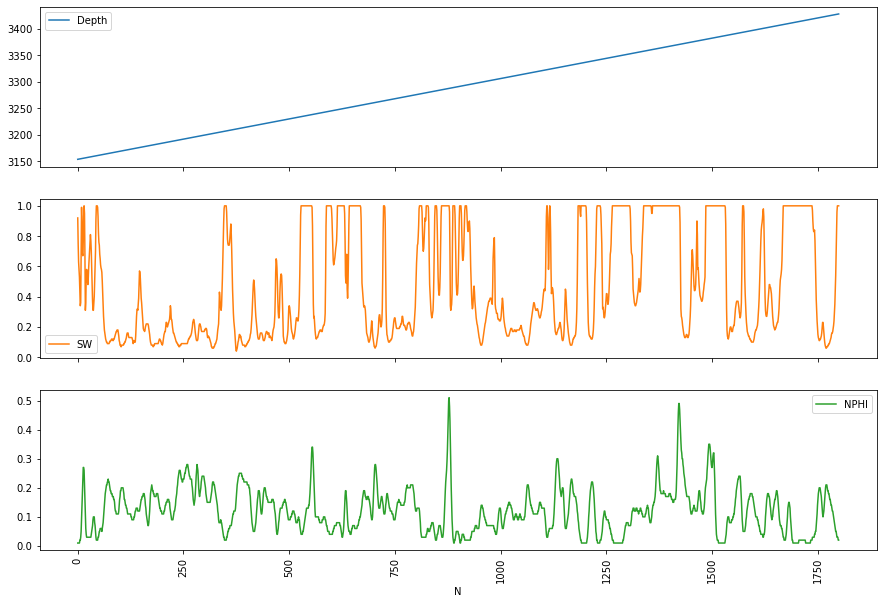

In [70]:
data = pd.read_excel("data/well_log.xlsx", sheet_name=0, nrows=1800)

plot_df = data[['Depth','SW', 'NPHI']]
plot_df.plot(subplots=True, figsize=(15, 10))
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [71]:
time_factor = np.array(data.Depth).reshape(-1,3)
neuron_factor = np.array(data.SW).reshape(-1,3)
trial_factor = np.array(data.NPHI).reshape(-1,3)
print(time_factor.shape, time_factor)

# observed2 = np.array(time_factor,neuron_factor,trial_factor)
observed = np.einsum('ir,jr,vr', time_factor, neuron_factor, trial_factor)
print(observed.shape)

(600, 3) [[3154.07 3154.22 3154.38]
 [3154.53 3154.68 3154.83]
 [3154.98 3155.14 3155.29]
 ...
 [3427.02 3427.17 3427.32]
 [3427.48 3427.63 3427.78]
 [3427.93 3428.09 3428.24]]
(600, 600, 600)


сохраним матрицы $A$, $B$, $C$ для последующего сравнения.

In [72]:
factors_actual = (normalize(time_factor), normalize(neuron_factor), normalize(trial_factor))

## Реализация тензорного разложения с помощью библиотек

Вызовите функцию разложения и передайте тензор и ранг (количество факторов). В **Tensorly** функция называется "parafac", которая реализует каноническое полиадическое (CP) разложение с помощью  ALS метода. Существует история возникновения этого названия, но оно также известно как Каноническая декомпозиция (CANDECOMP), а также параллельная факторизация (PARAFAC). В **tensortools** он называется "cp_als", который реализует то же самое.

Ниже приведен минимальный код для реализации CP разложения тензора в обеих библиотеках:
- Укажите тензор и ранг (количество факторов)
- Используйте функцию для разложения тензора
- Кроме того, мы можем восстановить оценку $M$, используя функцию "реконструировать", предусмотренную в скрипте.

In [73]:
X, rank = observed, 3

In [74]:
# TensorLy
weights, factors_tl = parafac(X, rank=rank)

In [75]:
# Восстановим исходный набор данных
M_tl = reconstruct(factors_tl)

In [76]:
# Определяем ошибку восстановления
rec_error_tl = np.mean((X-M_tl)**2)

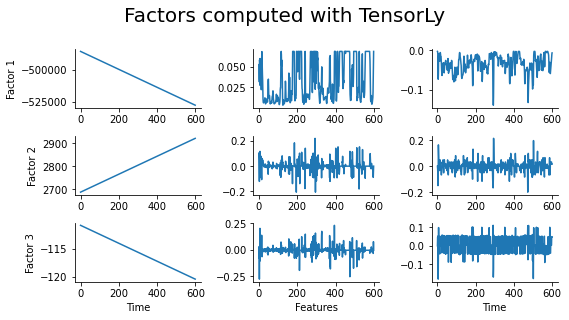

In [77]:
# Визуализируем факторы полученные с помощью Tensorly
plot_factors(factors_tl, d=3)
plt.suptitle("Factors computed with TensorLy", y=1.1, fontsize=20);

### Тензорное разложение через Numpy

В конечном счете, мы хотели бы свести к минимуму разницу между $ X $  и $ M $ (оценка модели, которая является приближением $ X $). Следовательно, мы можем сформулировать нашу функцию потерь как квадрат ошибки между $X$ и $M$:

$ M $ вычисляется с использованием трех матриц $A $, $ B $ и $ C$, все из которых мы не знаем. Один из способов найти их - оптимизировать для одной, одновременно исправляя две других. Как только мы оптимизируем одну из них, мы используем ее как фиксированную матрицу, оптимизируя для другой. И мы чередуем оптимизацию $A$, $B $ и $ C$ до сходимости или критерия остановки. Следовательно, мы собираемся записать нашу функцию потерь для каждой матрицы следующим образом:

Где $X_{(0)}$ обозначает нулевую моду, разворачивающий тензор X в матрицу, и так далее. и $ (B \dot C) ^ T$ обозначает произведение *Хатри-Рао*, который объединяет B и C в единую матрицу. 
В целом, это невыпуклая проблема; однако, когда мы оптимизируем одну матрицу за раз, это выпуклая проблема. Если вы хотите узнать больше о развертывании тензора в матрицу, нажмите сюда [ссылку](http://jeankossaifi.com/blog/unfolding.html ).

In [78]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):

    # a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))

        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())

    return a.T, b.T, c.T

In [79]:
factors_np = decompose_three_way(X, rank, verbose=False)

In [80]:
a, b, c = factors_np
factors = (normalize(a), normalize(b), normalize(c))

In [81]:
M_np = reconstruct(factors_np)
rec_error_np = np.mean((X-M_np)**2)

Сравнение между тремя подходами при оценке $X$.

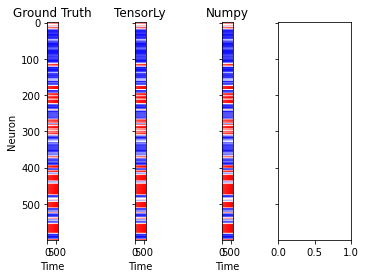

In [82]:
fig, axes = plt.subplots(1, 4, sharey=True)
tensors = [X, M_tl, M_np]
titles = ["Ground Truth", "TensorLy", "Numpy"]
trial_num = 50

for title, tensor, ax in zip(titles, tensors, axes):
    ax.imshow(tensor[:, :, trial_num].T, cmap='bwr', aspect=20)
    ax.set_xlabel("Time")
    ax.set_title(title)
axes[0].set_ylabel("Neuron");

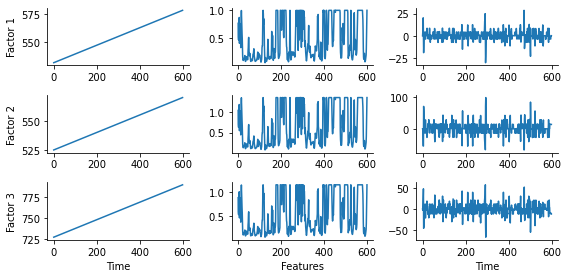

In [83]:
plot_factors(factors_np, d=3)

Оказывается, иногда факторы могут быть инвертированы. Однако, если один из них перевернут, то, безусловно, другой также должен быть перевернут. Следовательно, в зависимости от ожиданий и интерпретации, может потребоваться изменить некоторые факторы. Столбцы соответствуют факторам, а строки матрицам ($A$, $B$, $C$).

In [84]:
# a[:, 1] = a[:, 1] * -1
# b[:, 1] = b[:, 1] * -1
# c[:, 2] = c[:, 2] * -1

Нормализуем факторы, для того чтобы сравнить с ground true

In [85]:
factors = (normalize(a), normalize(b), normalize(c))

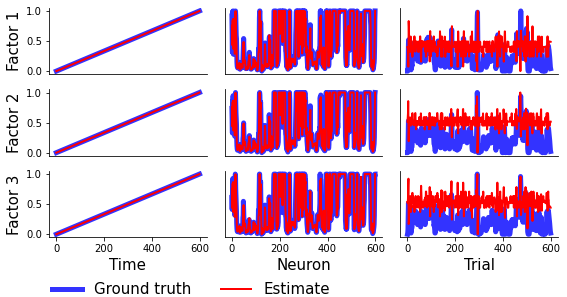

In [86]:
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors, factors_actual, factors_ind=[1, 0, 2], fig=fig);

### Сравнение подходов
#### Ошибка восстановления

In [87]:
import timeit

In [90]:
iter_num = 50
times = {'tl': [], 'tt': [], 'np': []}
rec_errors = {'tl': [], 'tt': [], 'np': []}

# TensorLy
for i in range(iter_num):
    start_time = timeit.default_timer()
    weights, factors_tl = parafac(X, rank=rank, n_iter_max=200)
    end_time = timeit.default_timer() - start_time
    times['tl'].append(end_time)
    M_tl = reconstruct(factors_tl)
    rec_error_tl = np.mean((X-M_tl)**2)
    rec_errors['tl'].append(rec_error_tl)
    print("TensorLy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

# Numpy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_np = decompose_three_way(X, rank, max_iter=200, verbose=False)
    end_time = timeit.default_timer() - start_time
    times['np'].append(end_time)
    M_np = reconstruct(factors_np)
    rec_error_np = np.mean((X-M_np)**2)
    rec_errors['np'].append(rec_error_np)
    print("Numpy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

TensorLy | Iteration: 1 / 50 | time take: 27.532686299997295 sec
TensorLy | Iteration: 2 / 50 | time take: 25.961243300000206 sec
TensorLy | Iteration: 3 / 50 | time take: 25.439516300000832 sec
TensorLy | Iteration: 4 / 50 | time take: 25.362112499999057 sec
TensorLy | Iteration: 5 / 50 | time take: 26.261485499999253 sec
TensorLy | Iteration: 6 / 50 | time take: 26.321579800001928 sec
TensorLy | Iteration: 7 / 50 | time take: 25.954813899999863 sec
TensorLy | Iteration: 8 / 50 | time take: 27.737246999997296 sec
TensorLy | Iteration: 9 / 50 | time take: 27.98286509999889 sec
TensorLy | Iteration: 10 / 50 | time take: 28.440376200000173 sec
TensorLy | Iteration: 11 / 50 | time take: 28.20100150000144 sec
TensorLy | Iteration: 12 / 50 | time take: 26.28941820000182 sec
TensorLy | Iteration: 13 / 50 | time take: 27.461581200001092 sec
TensorLy | Iteration: 14 / 50 | time take: 29.438515399997414 sec
TensorLy | Iteration: 15 / 50 | time take: 28.37610770000174 sec
TensorLy | Iteration: 1

C:\Users\User\anaconda3\lib\site-packages\tensorly\backend\core.py:910: RuntimeWarning: invalid value encountered in sqrt
  S = np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, np.sqrt(S))
C:\Users\User\anaconda3\lib\site-packages\tensorly\backend\core.py:911: RuntimeWarning: invalid value encountered in less_equal
  V = np.dot(matrix.T.conj(), U * np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, 1/S)[None, :])


TensorLy | Iteration: 42 / 50 | time take: 24.407115000001795 sec
TensorLy | Iteration: 43 / 50 | time take: 21.76690459999736 sec
TensorLy | Iteration: 44 / 50 | time take: 24.83409920000122 sec
TensorLy | Iteration: 45 / 50 | time take: 24.61759019999954 sec
TensorLy | Iteration: 46 / 50 | time take: 24.036460100000113 sec
TensorLy | Iteration: 47 / 50 | time take: 21.832720499998686 sec
TensorLy | Iteration: 48 / 50 | time take: 24.250887500002136 sec
TensorLy | Iteration: 49 / 50 | time take: 24.610962700000528 sec
TensorLy | Iteration: 50 / 50 | time take: 29.49817990000156 sec
Numpy | Iteration: 1 / 50 | time take: 300.68129129999943 sec
Numpy | Iteration: 2 / 50 | time take: 299.06804009999905 sec
Numpy | Iteration: 3 / 50 | time take: 287.3298665000002 sec
Numpy | Iteration: 4 / 50 | time take: 273.21751890000087 sec
Numpy | Iteration: 5 / 50 | time take: 270.73130610000226 sec
Numpy | Iteration: 6 / 50 | time take: 269.1955103 sec
Numpy | Iteration: 7 / 50 | time take: 274.841

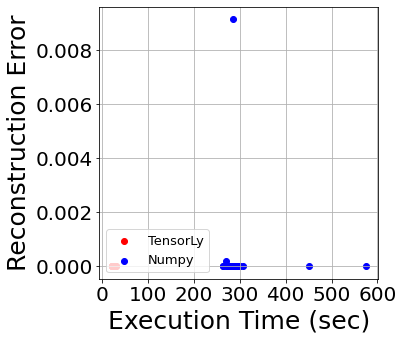

In [93]:
plt.figure(figsize=(5, 5)) #, dpi=200)
factor = 1e15
plt.scatter(np.array(times['tl']), np.array(rec_errors['tl']), c='red', label="TensorLy")
plt.scatter(np.array(times['np']), np.array(rec_errors['np']), c='b', label="Numpy")
plt.xlabel("Execution Time (sec)", fontsize=25)
plt.ylabel("Reconstruction Error", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower left", fontsize=13);
plt.grid()
# plt.savefig("metric-1.png", transparent=True, bbox_inches='tight')